In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from skimage import img_as_float
from skimage.exposure import equalize_hist
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from skimage.measure import block_reduce
from sklearn.utils import shuffle
import pandas as pd
from os import listdir

from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger, VisdomLogger
from torchvision.utils import make_grid
from tqdm import tqdm
import torchnet as tnt


# from tqdm import tqdm_notebook

import h5py

/home/dolorousrtur/anaconda3/envs/dipstereo/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Data:

In [2]:
def read_np_data(file):
    columns = ['label', 'PID', 'image', 'tumorMask']
    
    h5file = h5py.File(file)
    
    out_dict = {}
    
    out_dict['images'] = np.array(h5file['image'])
    out_dict['masks'] = np.array(h5file['tumorMask'])
    out_dict['labels'] = np.array(h5file['label'])
    
    
    return out_dict

In [3]:
# 0 for meningioma, 1 for glioma, 2 for pituitary tumor
NUM_CLASSES = 3

data = read_np_data('data_64.mat')

###### Check data:

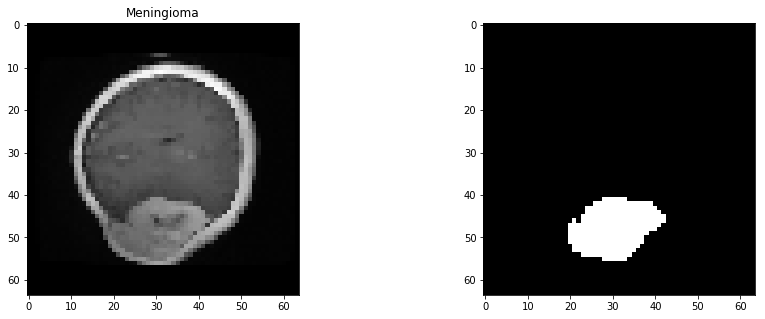

In [4]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(data['images'][4], cmap='gray')
ax[0].set_title('Meningioma')
ax[1].imshow(data['masks'][4], cmap='gray');

### Preprocessing:

 - ###### Augmentation:

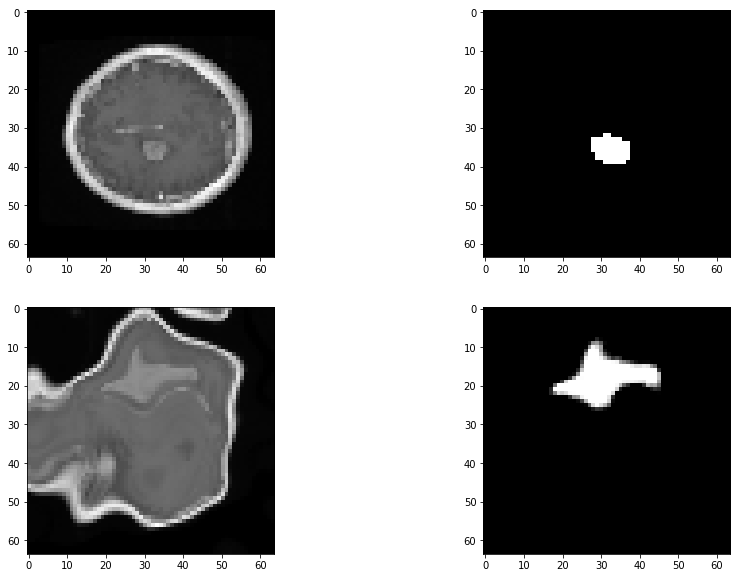

In [5]:
from utils import augment

img = data['images'][0]
mask = data['masks'][0]
augi, augm = augment(img, mask, factor=4)

fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].imshow(img, cmap='gray')
ax[0,1].imshow(mask, cmap='gray')
ax[1,0].imshow(augi, cmap='gray')
ax[1,1].imshow(augm, cmap='gray');

 - ###### Histogram equalization:

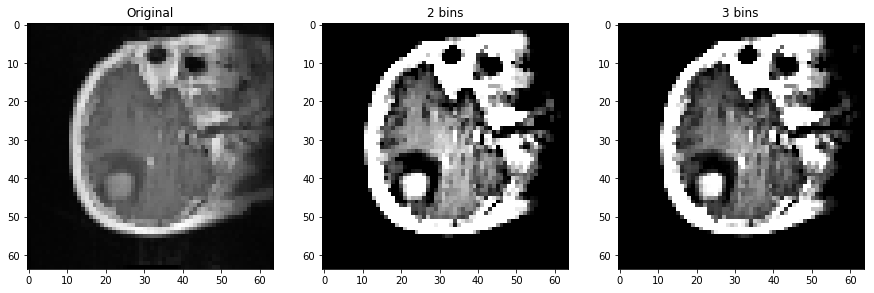

In [6]:
idx = 1
img = data['images'][idx]
mask = data['masks'][idx]
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(equalize_hist(img, nbins=2,mask=mask), cmap='gray')
ax[2].imshow(equalize_hist(img, nbins=3, mask=mask), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('2 bins')
ax[2].set_title('3 bins');

 - ###### Prepare data and split into test / train:

In [7]:
from sklearn.model_selection import train_test_split

def get_train_test_data(data_dict, test_ratio, random_state=None):
    imgs = data_dict['images']
    masks = data_dict['masks']
    labels = data_dict['labels']
    
#     print(imgs.shape)
#     print(masks.shape)
#     print(labels.shape)
    
#     print(imgs.dtype)
#     print(masks.dtype)
#     print(labels.dtype)
    

    imgs_train, imgs_test, masks_train, masks_test, labels_train, labels_test = \
                        train_test_split(imgs, masks, labels, test_size=test_ratio, random_state=random_state)
    
    train_dict = {}
    train_dict['images'] = imgs_train
    train_dict['masks'] = masks_train
    train_dict['labels'] = labels_train
    
    
    test_dict = {}
    test_dict['images'] = imgs_test
    test_dict['masks'] = masks_test
    test_dict['labels'] = labels_test
    
    return train_dict, test_dict
    

In [8]:
data_train, data_test = get_train_test_data(data, 0.2)

In [9]:
from utils import tumor_data_np

train_data = tumor_data_np(data_train['images'], data_train['labels'])
test_data = tumor_data_np(data_test['images'], data_test['labels'])

batch_size = 5

train_feeder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_feeder = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=False)

### Capsnet:

In [10]:
from capsnet import CapsuleNet, CapsuleLoss

# def buildEngine

engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_accuracy = tnt.meter.ClassErrorMeter(accuracy=True)
confusion_meter = tnt.meter.ConfusionMeter(NUM_CLASSES, normalized=True)

def reset_meters():
    meter_accuracy.reset()
    meter_loss.reset()
    confusion_meter.reset()

In [11]:
model = model = CapsuleNet(img_shape=(64, 64), n_pcaps=8, n_ccaps=3, conv_channels=64, n_iterations=3).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = CapsuleLoss()

In [ ]:
def get_iterator(mode):
    
    if mode:
        data = torch.FloatTensor(data_train['images'])
        data = data.unsqueeze(1)
        labels = torch.LongTensor(data_train['labels'])
    else:
        data = torch.FloatTensor(data_test['images'])
        data = data.unsqueeze(1)
        labels = torch.LongTensor(data_test['labels'])

    
    tensor_dataset = tnt.dataset.TensorDataset([data, labels])

    return tensor_dataset.parallel(batch_size=batch_size, num_workers=4, shuffle=mode)

def processor(sample):
    
    data, labels, training = sample

    data = (data.float())
    labels = torch.LongTensor(labels)
    
    labels = torch.sparse.torch.eye(NUM_CLASSES).index_select(dim=0, index=labels)

    data = Variable(data).cuda()
    labels = Variable(labels).cuda()

#     print(data.shape)
#     print(type(data.data))
#     print(labels.shape)
#     print(type(labels.data))
    
    if training:
        classes, reconstructions = model(data, labels)
    else:
        classes, reconstructions = model(data)
        
#     print(classes.shape)
#     print(type(classes.data))
#     print(classes[0])
#     print(reconstructions.shape)
#     print(type(reconstructions.data))

    loss = criterion(data, labels, classes, reconstructions)

    return loss, classes

def on_sample(state):
    state['sample'].append(state['train'])


def on_forward(state):
    meter_accuracy.add(state['output'].data, torch.LongTensor(state['sample'][1]))
    confusion_meter.add(state['output'].data, torch.LongTensor(state['sample'][1]))
    meter_loss.add(state['loss'].data[0])


def on_start_epoch(state):
    reset_meters()
    state['iterator'] = tqdm(state['iterator'])
    
def on_end_epoch(state):
    print('[Epoch %d] Training Loss: %.4f (Accuracy: %.2f%%)' % (
        state['epoch'], meter_loss.value()[0], meter_accuracy.value()[0]))
    
    reset_meters()

    engine.test(processor, get_iterator(False))

    print('[Epoch %d] Testing Loss: %.4f (Accuracy: %.2f%%)' % (
        state['epoch'], meter_loss.value()[0], meter_accuracy.value()[0]))


In [ ]:
engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epoch

engine.train(processor, get_iterator(True), maxepoch=30, optimizer=optimizer)

100%|██████████| 491/491 [00:35<00:00, 13.70it/s]

[Epoch 1] Training Loss: 0.2887 (Accuracy: 63.97%)



  0%|          | 0/491 [00:00<?, ?it/s]

[Epoch 1] Testing Loss: 0.2565 (Accuracy: 69.98%)


100%|██████████| 491/491 [00:35<00:00, 14.00it/s]

[Epoch 2] Training Loss: 0.2386 (Accuracy: 72.79%)



  0%|          | 0/491 [00:00<?, ?it/s]

[Epoch 2] Testing Loss: 0.2253 (Accuracy: 75.20%)


100%|██████████| 491/491 [00:35<00:00, 13.94it/s]

[Epoch 3] Training Loss: 0.2222 (Accuracy: 76.54%)



  0%|          | 0/491 [00:00<?, ?it/s]

[Epoch 3] Testing Loss: 0.2223 (Accuracy: 77.16%)


100%|██████████| 491/491 [00:35<00:00, 13.95it/s]

[Epoch 4] Training Loss: 0.2135 (Accuracy: 78.50%)



  0%|          | 0/491 [00:00<?, ?it/s]

[Epoch 4] Testing Loss: 0.2171 (Accuracy: 77.49%)


100%|██████████| 491/491 [00:35<00:00, 13.96it/s]

[Epoch 5] Training Loss: 0.2028 (Accuracy: 80.82%)



  0%|          | 0/491 [00:00<?, ?it/s]

[Epoch 5] Testing Loss: 0.2128 (Accuracy: 81.08%)


100%|██████████| 491/491 [00:35<00:00, 14.02it/s]

[Epoch 6] Training Loss: 0.1971 (Accuracy: 83.35%)



  0%|          | 0/491 [00:00<?, ?it/s]

[Epoch 6] Testing Loss: 0.2074 (Accuracy: 81.57%)


100%|██████████| 491/491 [00:35<00:00, 14.00it/s]

[Epoch 7] Training Loss: 0.1871 (Accuracy: 86.86%)



  0%|          | 0/491 [00:00<?, ?it/s]

[Epoch 7] Testing Loss: 0.1901 (Accuracy: 87.77%)


 39%|███▉      | 191/491 [00:13<00:21, 13.87it/s]